In [1]:
#Importing all the necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time

In [2]:
#Importing all the necessary libraries
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import sqrt, udf, struct, count, when
from pyspark.sql.functions import lit
from pyspark.sql.types import StructType,StructField, StringType, IntegerType, FloatType, DoubleType
from pyspark.sql.window import Window
from pyspark.sql.functions import col, avg,stddev,mean,sum as spark_sum, sqrt, min as spark_min,max as spark_max, monotonically_increasing_id, when, length, log, isnull, isnan, count

In [3]:
import time

In [4]:
from delta import *

In [5]:
builder = pyspark.sql.SparkSession.builder.appName("Group14") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") \
    .config("spark.executor.instances",6) \
    .master("yarn")

spark = configure_spark_with_delta_pip(builder).getOrCreate()

23/04/26 22:47:02 WARN Utils: Your hostname, Swains-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 152.94.139.216 instead (on interface en0)
23/04/26 22:47:02 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
:: loading settings :: url = jar:file:/Users/swainstha/opt/anaconda3/lib/python3.9/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/swainstha/.ivy2/cache
The jars for the packages stored in: /Users/swainstha/.ivy2/jars
io.delta#delta-core_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-5c3e2c16-8bac-42cc-88f2-f5628effb2be;1.0
	confs: [default]
	found io.delta#delta-core_2.12;2.3.0 in central
	found io.delta#delta-storage;2.3.0 in central
	found org.antlr#antlr4-runtime;4.8 in central
:: resolution report :: resolve 105ms :: artifacts dl 4ms
	:: modules in use:
	io.delta#delta-core_2.12;2.3.0 from central in [default]
	io.delta#delta-storage;2.3.0 from central in [default]
	org.antlr#antlr4-runtime;4.8 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   3   |   0

23/04/26 22:47:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/04/26 22:47:03 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [6]:
# Disable logging
import logging

logger = spark._jvm.org.apache.log4j
logger.LogManager.getLogger("org").setLevel(logger.Level.OFF)
logger.LogManager.getLogger("akka").setLevel(logger.Level.OFF)

spark.conf.set("spark.driver.log.level","OFF")

In [14]:
#Define the schema
schema = StructType([ \
    StructField("user_id",StringType(),True), \
    StructField("name",StringType(),True), \
    StructField("review_count",IntegerType(),True), \
    StructField("yelping_since", StringType(), True), \
    StructField("friends", IntegerType(), True), \
    StructField("useful", IntegerType(), True), \
    StructField("funny", IntegerType(), True), \
                     
    StructField("cool",IntegerType(),True), \
    StructField("fans",IntegerType(),True), \
    StructField("elite", IntegerType(), True), \
    StructField("average_stars", FloatType(), True), \
    StructField("compliment_hot", IntegerType(), True), \
                     
    StructField("compliment_more",IntegerType(),True), \
    StructField("compliment_profile",IntegerType(),True), \
    StructField("compliment_cute", IntegerType(), True), \
    StructField("compliment_list", IntegerType(), True), \
    StructField("compliment_note", IntegerType(), True), \
                     
    StructField("compliment_plain",IntegerType(),True), \
    StructField("compliment_cool",IntegerType(),True), \
    StructField("compliment_funny", IntegerType(), True), \
    StructField("compliment_writer", IntegerType(), True), \
    StructField("compliment_photos", IntegerType(), True) \
  ])

In [15]:
#read the csv file
file = "hdfs://namenode:9000/dat/yelpuser.csv"
df = spark.read.format("csv") \
      .option("header", False) \
      .schema(schema) \
      .load(file)

#Print the schema
df.printSchema()

# Cache the DataFrame
df.cache()

root
 |-- user_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: integer (nullable = true)
 |-- yelping_since: string (nullable = true)
 |-- friends: integer (nullable = true)
 |-- useful: integer (nullable = true)
 |-- funny: integer (nullable = true)
 |-- cool: integer (nullable = true)
 |-- fans: integer (nullable = true)
 |-- elite: integer (nullable = true)
 |-- average_stars: float (nullable = true)
 |-- compliment_hot: integer (nullable = true)
 |-- compliment_more: integer (nullable = true)
 |-- compliment_profile: integer (nullable = true)
 |-- compliment_cute: integer (nullable = true)
 |-- compliment_list: integer (nullable = true)
 |-- compliment_note: integer (nullable = true)
 |-- compliment_plain: integer (nullable = true)
 |-- compliment_cool: integer (nullable = true)
 |-- compliment_funny: integer (nullable = true)
 |-- compliment_writer: integer (nullable = true)
 |-- compliment_photos: integer (nullable = true)



DataFrame[user_id: string, name: string, review_count: int, yelping_since: string, friends: int, useful: int, funny: int, cool: int, fans: int, elite: int, average_stars: float, compliment_hot: int, compliment_more: int, compliment_profile: int, compliment_cute: int, compliment_list: int, compliment_note: int, compliment_plain: int, compliment_cool: int, compliment_funny: int, compliment_writer: int, compliment_photos: int]

In [16]:
#Show few rows in the dataset 
df.show(5)

+--------------------+------+------------+-------------+-------+------+-----+----+-----+-----+-------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+----------------+-----------------+-----------------+
|             user_id|  name|review_count|yelping_since|friends|useful|funny|cool| fans|elite|average_stars|compliment_hot|compliment_more|compliment_profile|compliment_cute|compliment_list|compliment_note|compliment_plain|compliment_cool|compliment_funny|compliment_writer|compliment_photos|
+--------------------+------+------------+-------------+-------+------+-----+----+-----+-----+-------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+----------------+-----------------+-----------------+
|qVc8ODYU5SZjKXVBg...|Walker|         585|2007-01-25 16|   7217|  1259| 5994|2007|14995|  267|         3.91|           25

In [17]:
#Total number of rows in the dataset
df.count()

29398

In [18]:
#Number of columns in the dataset
len(df.columns)

22

In [28]:
#check for nan or null values
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-------+----+------------+-------------+-------+------+-----+-----+----+-----+-------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+----------------+-----------------+-----------------+
|user_id|name|review_count|yelping_since|friends|useful|funny| cool|fans|elite|average_stars|compliment_hot|compliment_more|compliment_profile|compliment_cute|compliment_list|compliment_note|compliment_plain|compliment_cool|compliment_funny|compliment_writer|compliment_photos|
+-------+----+------------+-------------+-------+------+-----+-----+----+-----+-------------+--------------+---------------+------------------+---------------+---------------+---------------+----------------+---------------+----------------+-----------------+-----------------+
|      0|   3|           0|            0|      0|     0|    0|19675|   0|    0|            0|             0|              0|                 0|              0|       

In [29]:
#drop the user_id and name column
df = df.drop("user_id")
df = df.drop("name")
df = df.drop("compliment_photos")
df = df.drop("cool")
df = df.drop("yelping_since")

In [30]:
#number of columns after dropping irrelevant fields
len(df.columns)

17

In [31]:
#convert to pandas for finding correlation among columns
dfp = df.toPandas()

In [32]:
#find correlation amongst columns
dfp.corr()

,review_count,friends,useful,funny,fans,elite,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer
review_count,1.000000,0.711769,0.619039,0.647537,0.513226,0.472279,-0.044503,0.372344,0.272825,0.166503,0.227501,0.176971,0.447449,0.372380,0.428973,0.428973,0.461522
friends,0.711769,1.000000,0.960604,0.991589,0.574577,0.574193,-0.008711,0.635415,0.419372,0.283000,0.341022,0.262225,0.657270,0.627849,0.719779,0.719779,0.726829
useful,0.619039,0.960604,1.000000,0.975895,0.492673,0.523410,-0.007591,0.634971,0.407670,0.281452,0.345121,0.254847,0.615432,0.586199,0.703595,0.703595,0.699899
funny,0.647537,0.991589,0.975895,1.000000,0.534006,0.539248,0.001484,0.647211,0.418956,0.288027,0.342214,0.258147,0.644899,0.618947,0.726641,0.726641,0.720056
fans,0.513226,0.574577,0.492673,0.534006,1.000000,0.574001,0.033652,0.422232,0.255388,0.150471,0.296067,0.170375,0.502204,0.511819,0.480130,0.480130,0.460217
elite,0.472279,0.574193,0.523410,0.539248,0.574001,1.000000,0.004782,0.379668,0.243709,0.144314,0.294399,0.171907,0.456956,0.476199,0.438780,0.438780,0.422488
average_stars,-0.044503,-0.008711,-0.007591,0.001484,0.033652,0.004782,1.000000,0.003194,-0.004146,-0.000604,0.000672,-0.002399,-0.001508,0.007923,0.002911,0.002911,-0.000883
compliment_hot,0.372344,0.635415,0.634971,0.647211,0.422232,0.379668,0.003194,1.000000,0.689254,0.592210,0.739594,0.562339,0.849045,0.734313,0.937841,0.937841,0.847788
compliment_more,0.272825,0.419372,0.407670,0.418956,0.255388,0.243709,-0.004146,0.689254,1.000000,0.972656,0.823449,0.944633,0.796831,0.519931,0.663160,0.663160,0.781292
compliment_profile,0.166503,0.283000,0.281452,0.288027,0.150471,0.144314,-0.000604,0.592210,0.972656,1.000000,0.786350,0.949975,0.699987,0.418886,0.549567,0.549567,0.681347


In [33]:
#drop the columns below because they have a very low correlation with other columns
df = df.drop( "fans", "average_stars")

In [34]:
#New number of columns
len(df.columns)

15

In [35]:
#sum all the compliments to compliments_given
df = df.withColumn("compliments_given", col("compliment_hot")+col("compliment_more")+col("compliment_profile")+col("compliment_note")+col("compliment_plain")+col("compliment_cool")+col("compliment_funny")+col("compliment_writer")+col("compliment_cute")+col("compliment_list"))


In [36]:
#remove those columns that were summed
df = df.drop("compliment_hot", "compliment_more", "compliment_profile", "compliment_note", "compliment_plain", "compliment_cool", "compliment_funny", "compliment_writer","compliment_cute","compliment_list")


In [37]:
#sum these columns to compliments_received
df = df.withColumn("compliments_received", col("useful")+col("funny"))

In [38]:
#drop the summed columns
df = df.drop("useful", "funny")

In [39]:
df.show()

+------------+-------+-----+-----------------+--------------------+
|review_count|friends|elite|compliments_given|compliments_received|
+------------+-------+-----+-----------------+--------------------+
|         585|   7217|  267|             2693|                7253|
|        4333|  43091| 3138|            18685|               40347|
|         665|   2086|   52|              567|                2013|
|         224|    512|   28|              127|                 629|
|          79|     29|    1|                4|                  22|
|        1221|  14953| 1357|            15384|               21151|
|          12|      6|    1|                1|                   1|
|         358|    399|   23|               56|                 245|
|          40|    109|    7|               25|                  86|
|         109|    154|    4|               13|                  43|
|           4|      1|    1|                0|                   1|
|         535|   1130|   31|              209|  

In [40]:
df

DataFrame[review_count: int, friends: int, elite: int, compliments_given: int, compliments_received: int]

In [41]:
dfp.describe()

,review_count,friends,useful,funny,fans,elite,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer
count,29398.000000,29398.000000,29398.000000,29398.000000,29398.000000,29398.000000,29398.000000,29398.000000,29398.000000,29398.000000,29398.000000,29398.000000,29398.000000,29398.000000,29398.000000,29398.000000,29398.000000
mean,172.037724,476.623206,224.544153,298.495714,173.625213,16.508776,3.837293,25.819443,3.906592,2.836928,2.109803,1.304817,18.051908,41.590210,38.153922,38.153922,15.100313
std,369.394743,2699.551489,1816.941171,2323.983803,408.185862,100.720936,0.513744,219.450874,38.586167,57.806134,23.054536,23.087356,119.174260,382.939193,295.524218,295.524218,113.401363
min,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,21.000000,24.000000,5.000000,6.000000,20.000000,1.000000,3.570000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,57.000000,76.000000,20.000000,24.000000,65.000000,3.000000,3.850000,1.000000,1.000000,0.000000,0.000000,0.000000,2.000000,2.000000,2.000000,2.000000,1.000000
75%,174.750000,276.000000,87.000000,106.000000,181.000000,10.000000,4.140000,6.000000,2.000000,1.000000,0.000000,0.000000,7.000000,9.000000,10.000000,10.000000,5.000000
max,17473.000000,206296.000000,185823.000000,195814.000000,14995.000000,12497.000000,5.000000,12391.000000,4347.000000,7039.000000,1744.000000,2607.000000,8616.000000,28974.000000,13280.000000,13280.000000,7309.000000


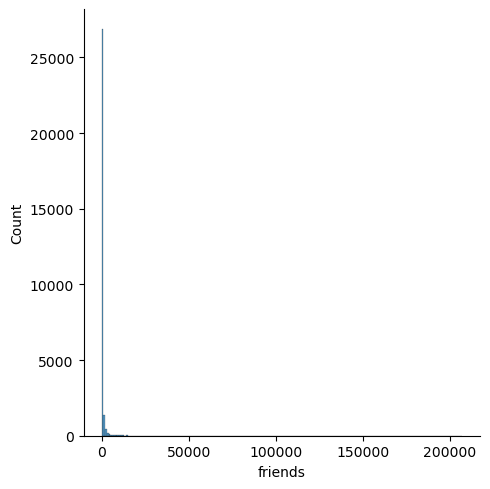

In [40]:
#histogram plot. Skewness in the right
sns.displot(dfp["friends"],binwidth= 1000)
plt.show()

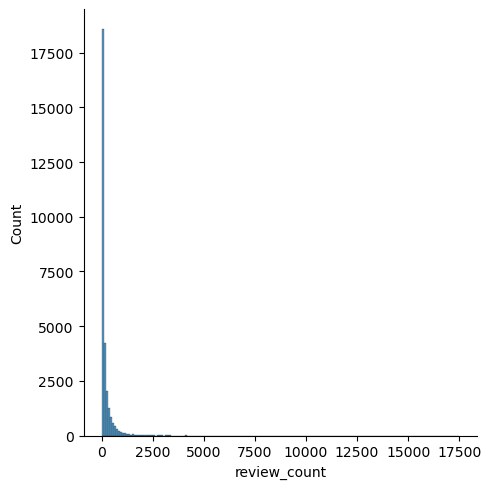

In [41]:
#histogram plot. Skewness in the right
sns.displot(dfp["review_count"],binwidth=100)
plt.show()

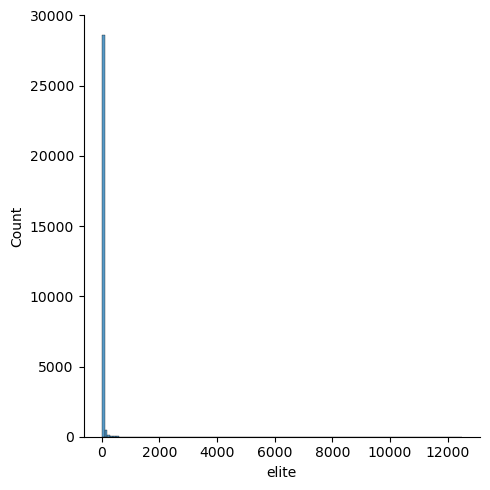

In [42]:
#histogram plot. Skewness in the right
sns.displot(dfp["elite"],binwidth=100)
plt.show()

In [44]:
#calculate approx quantile of 0.01 and 0.9
d = {}
for column in df.columns:
      d[column] = df.approxQuantile(column,[0.01,0.9],0.25)
      print(column+" done")

review_count done
friends done
elite done
compliments_given done
compliments_received done


In [45]:
#print quantiles for each column
print(d)

{'review_count': [1.0, 17473.0], 'friends': [0.0, 206296.0], 'elite': [0.0, 12497.0], 'compliments_given': [0.0, 80800.0], 'compliments_received': [0.0, 381637.0]}


In [46]:
# Log transform the columns and limit the extreme ends to 0.01 and 0.9 quantiles
for column in df.columns:
    df = df.withColumn(column, log(when(df[column] < d[column][0], d[column][0])
                                   .when(df[column] > d[column][1], d[column][1])
                                   .otherwise(df[column]) + 1).alias(column))
    print(column + " done")


review_count done
friends done
elite done
compliments_given done
compliments_received done


In [47]:
df.printSchema()

root
 |-- review_count: double (nullable = true)
 |-- friends: double (nullable = true)
 |-- elite: double (nullable = true)
 |-- compliments_given: double (nullable = true)
 |-- compliments_received: double (nullable = true)



In [47]:
dfpp = df.toPandas()

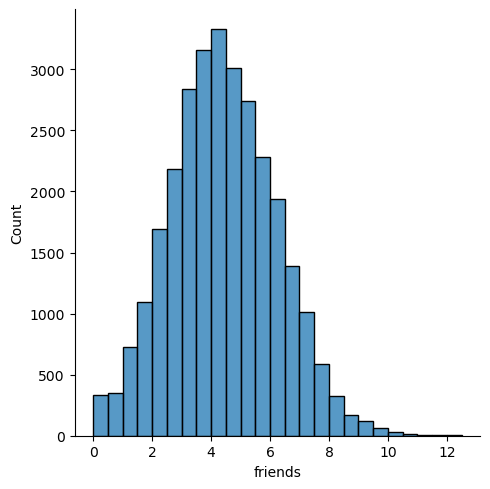

In [48]:
#after log transform
sns.displot(dfpp["friends"],binwidth=0.5)
plt.show()

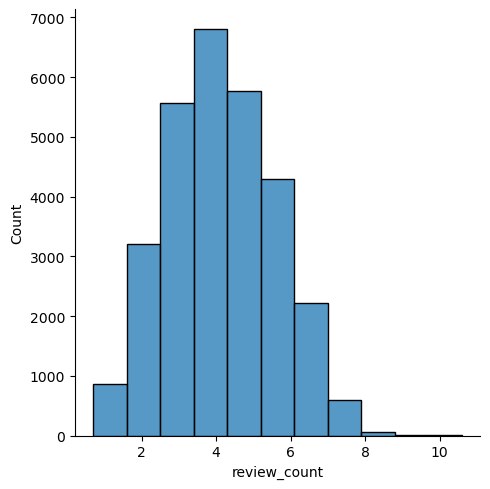

In [49]:
#after log transform
sns.displot(dfpp["review_count"],binwidth = 0.9)
plt.show()

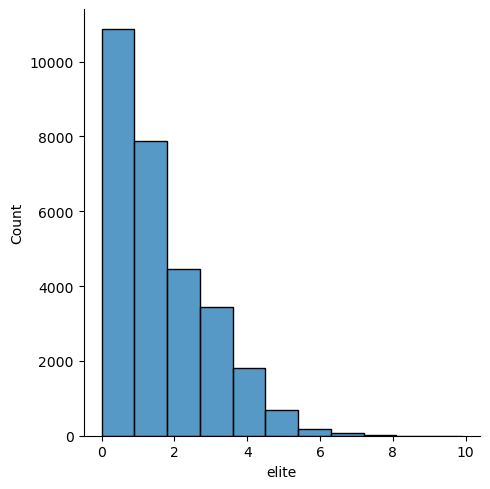

In [50]:
#after log transform
sns.displot(dfpp["elite"],binwidth = 0.9)
plt.show()

In [51]:
#after log transform
dfpp.describe()

,review_count,friends,elite,compliments_given,compliments_received
count,29398.000000,29398.000000,29398.000000,29398.000000,29398.000000
mean,4.125906,4.418513,1.596074,2.732068,3.947974
std,1.449959,1.793348,1.352804,1.923847,2.002190
min,0.693147,0.000000,0.000000,0.000000,0.000000
25%,3.091042,3.218876,0.693147,1.386294,2.484907
50%,4.060443,4.343805,1.386294,2.397895,3.806662
75%,5.169059,5.624018,2.397895,3.988984,5.278115
max,9.768469,12.237072,9.433324,11.299745,12.852228


In [48]:
#To save in a delta table
#df.write.mode("overwrite").format("delta").saveAsTable("table", path = "finalData")
df.write.mode("overwrite").format("delta").saveAsTable("table", path = "hdfs://namenode:9000/dat/finalData")

In [49]:

dff = spark.read.format("delta").load("hdfs://namenode:9000/dat/finalData")

In [50]:
class KMeans:
    def __init__(self, n_clusters=2, max_itr=100):
        self.n_clusters = n_clusters
        self.max_itr = max_itr
    
    def calculate_distance(self, centroids, data):
        distance = centroids.crossJoin(data)
        columns = data.columns
        columns.remove("id")
        for colname in columns:
            distance = distance.withColumn(colname, col(colname) - col("centroid_" + colname))
        for column in columns:
            distance = distance.drop("centroid_"+column)
        distance = distance.withColumn("distance", sqrt(sum(col(colname) ** 2 for colname in columns)))
        return distance
    
    def calculate_difference(self, centroid1, centroid2):
        
        centroid1 = centroid1.sort("centroid_id")
        centroid2 = centroid2.sort("centroid_id")
        for column in centroid1.columns:
            if column != "centroid_id":
                centroid1 = centroid1.withColumnRenamed(column, "first_"+column)
        distance = centroid1.join(centroid2, ["centroid_id"])
        columns = centroid2.columns
        columns.remove("centroid_id")
        
        for colname in columns:
            distance = distance.withColumn(colname, col(colname) - col("first_" + colname))
        for column in columns:
            distance = distance.drop("first_"+column)
        
        distance = distance.withColumn("distance", sqrt(sum(col(colname) ** 2 for colname in columns)))
        diff = distance.agg(spark_sum("distance").alias("sum_distance")).first()['sum_distance']
        return diff == 0
    
    def find_labels(self, distance):
        min_distance_col = "min_distance"
        win = Window.partitionBy("id")
        distance = distance.withColumn(min_distance_col, spark_min("distance").over(win))
        distance =  distance.withColumn("label", when(col("distance") == col(min_distance_col), col("centroid_id")).otherwise(None))
        distance = distance.na.drop(subset=["label"])
        for column in distance.columns:
            if (column != "label") and (column != "id"):
                distance = distance.drop(column)
        return distance
        
    
    def initialize_centroids(self, data):
        centroids = data.sample(False, 1.0 / self.n_clusters, 3).limit(self.n_clusters)
        
        for column in centroids.columns:
            centroids = centroids.withColumnRenamed(column, "centroid_"+column)
        centroids = centroids.withColumn("centroid_id", monotonically_increasing_id())
        return centroids

    
    def compute_centroids(self, data, labels):
        columns = data.columns
        columns.remove("id")
        centroids = data.join(labels, "id").groupBy("label").agg(*(avg(col(colname)).alias("centroid_"+colname) for colname in columns))
        centroids = centroids.withColumnRenamed("label", "centroid_id")
        centroids = centroids.drop("id")
        return centroids
    
    def fit(self, data):

        # Add an id column to the data_df for joining purposes
        data = data.withColumn("id", monotonically_increasing_id())
        
        # Initialize centroids
        self.centroids = self.initialize_centroids(data)

        # Iterate for max_itr
        for i in range(1,self.max_itr+1):
            start = time.time()

            # Calculate distance from data points to centroids
            distance = self.calculate_distance(self.centroids, data)
            
            # Assign labels to data points
            labels = self.find_labels(distance)
            
            # Compute new centroids
            old_centroids = self.centroids
            self.centroids = self.compute_centroids(data, labels)
            
            
            if i%5==0:
                if self.calculate_difference(old_centroids, self.centroids):
                    break
            end = time.time()
            print("Iteration ",i, " time: ", end-start)
        
        # Assign final labels
        self.labels = labels.select("id", "label")
        
    def predict(self, data):
        # Add an id column to the data_df for joining purposes
        data = data.withColumn("id", monotonically_increasing_id())

        # Calculate distance from data points to centroids
        distance = self.calculate_distance(self.centroids, data)

        # Assign labels to data points
        labels = self.find_labels(distance)
        
        # Return labels
        return labels.select("id", "label")

In [51]:
kmeans = KMeans(n_clusters=3, max_itr=50)

In [ ]:
dff.cache()

In [52]:
start = time.time()
kmeans.fit(dff)
end = time.time()
print("time taken",end - start)

Iteration  1  time:  0.13025307655334473
Iteration  2  time:  0.16550397872924805
Iteration  3  time:  0.10921311378479004
Iteration  4  time:  0.1241006851196289
Iteration  5  time:  4.3077168464660645
Iteration  6  time:  0.16693115234375
Iteration  7  time:  0.18288493156433105
Iteration  8  time:  0.1845691204071045
Iteration  9  time:  0.20372772216796875
Iteration  10  time:  7.953126907348633
Iteration  11  time:  0.24525094032287598
Iteration  12  time:  0.2512948513031006
Iteration  13  time:  0.2654910087585449
Iteration  14  time:  0.28711605072021484


Iteration  15  time:  12.720131158828735
Iteration  16  time:  0.35149097442626953
Iteration  17  time:  0.344102144241333
Iteration  18  time:  0.3639669418334961
Iteration  19  time:  0.4177987575531006
Iteration  20  time:  17.852267026901245
time taken 46.70939517021179


In [53]:
#show the centroids
kmeans.centroids.show()

+-----------+---------------------+-----------------+-------------------+--------------------------+-----------------------------+
|centroid_id|centroid_review_count| centroid_friends|     centroid_elite|centroid_compliments_given|centroid_compliments_received|
+-----------+---------------------+-----------------+-------------------+--------------------------+-----------------------------+
|          0|    4.440276234588525|4.784178604248924|  1.620353179972554|         2.927738211431316|            4.321031294075814|
|          1|   2.7634662789896267|2.710847843180503|0.47815486326923157|         1.013402771295903|           2.0417145999172224|
|          2|    6.064361924181287| 6.90123803673662|  3.623994246869273|         5.553376477562026|            6.785188497257751|
+-----------+---------------------+-----------------+-------------------+--------------------------+-----------------------------+



In [54]:
#sample some data
testData = df.sample(False, 1.0 / 10, 3).limit(3)

In [55]:
#Predict the labels
predicted = kmeans.predict(testData)

In [56]:
predicted.show()

+---+-----+
| id|label|
+---+-----+
|  0|    2|
|  1|    2|
|  2|    0|
+---+-----+

